In [108]:
import numpy as np
import os
import cv2
from insightface.app import FaceAnalysis
from glob import glob
from tqdm import tqdm
from collections import defaultdict
from PIL import Image
from IPython.display import display, Image

In [120]:
def get_averages(names, scores):
    d = defaultdict(list)
    for n, s in zip(names, scores):
        d[n].append(s)

    averages = {}
    for n, s in d.items():
        averages[n] = np.mean(s)
    return averages

def judge_sim(known_embeddings, known_names, unknown_embeddings, threshold):
    pred_names = []
    for emb in unknown_embeddings:
        scores = np.dot(emb, known_embeddings.T)
        scores = np.clip(scores, 0., None)

        averages = get_averages(known_names, scores)
        pred = sorted(averages, key=lambda x: averages[x], reverse=True)[0]
        print(averages)
        score = averages[pred]

        if score > threshold:
            pred_names.append(pred)
        else:
            pred_names.append(None)
    
    return pred_names

def draw_on(img, faces, name):
    dimg = img.copy()
    for i in range(len(faces)):
        face = faces[i]
        box = face.bbox.astype(int)
        color = (0, 0, 255)
        cv2.rectangle(dimg, (box[0], box[1]), (box[2], box[3]), color, 2)
        if face.kps is not None:
            kps = face.kps.astype(int)
            #print(landmark.shape)
            for l in range(kps.shape[0]):
                color = (0, 0, 255)
                if l == 0 or l == 3:
                    color = (0, 255, 0)
                cv2.circle(dimg, (kps[l][0], kps[l][1]), 1, color, 2)
        cv2.putText(dimg, name[i], (box[0]-1, box[1]-4),cv2.FONT_HERSHEY_COMPLEX,0.7,(0,255,0),1)

    return dimg

In [110]:
known_names = []
known_embeddings = []
app_pre = FaceAnalysis(name='buffalo_s',root='~/.insightface/models/')
app_pre.prepare(ctx_id=0, det_size=(640, 640))

Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /Users/tayamayuto/.insightface/models/models/buffalo_s/1k3d68.onnx landmark_3d_68 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /Users/tayamayuto/.insightface/models/models/buffalo_s/2d106det.onnx landmark_2d_106 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /Users/tayamayuto/.insightface/models/models/buffalo_s/det_500m.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /Users/tayamayuto/.insightface/models/models/buffalo_s/genderage.onnx genderage ['None', 3, 96, 96] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /Users/tayamayuto/.insightface/models/models/buffalo_s/w6

In [111]:
select_data = 'lfw'

In [112]:
players = os.listdir(f'/Users/tayamayuto/Face_recognition_IF/data/{select_data}')

for player in tqdm(players):
    print(player)
    player_embeddings, player_names = [], []

    img_paths = glob(f'/Users/tayamayuto/Face_recognition_IF/data/{select_data}/{player}/*')
    
    for img_path in img_paths:
        img = cv2.imread(img_path)
        if img is None: continue

        faces = app_pre.get(np.array(img))
        if len(faces) == 0 : continue
        player_embeddings.append(faces[0].embedding)
        player_names.append(player)

        if len(known_embeddings) == 10: break
    
    player_embeddings = np.stack(player_embeddings, axis=0)
    known_embeddings.append(player_embeddings)
    known_names += player_names
known_embeddings = np.concatenate(known_embeddings, axis=0)
        

  0%|          | 0/606 [00:00<?, ?it/s]

Salma_Hayek


  0%|          | 3/606 [00:01<03:51,  2.61it/s]

Shinya_Taniguchi
Jacqueline_Marris
Hank_Aaron


  1%|          | 5/606 [00:01<02:35,  3.87it/s]

Cathy_Freeman
Nizar_Trabelsi


  1%|          | 6/606 [00:01<02:09,  4.62it/s]

Alison_Lohman


  1%|          | 7/606 [00:02<02:13,  4.49it/s]

Duane_Lee_Chapman


  1%|▏         | 9/606 [00:02<02:00,  4.96it/s]

Andre_Smith
Charles_Rogers


  2%|▏         | 11/606 [00:02<01:30,  6.61it/s]

Anne_Donovan
Caroline_Link
Bryan_Murray


  2%|▏         | 13/606 [00:02<01:11,  8.30it/s]

Mathias_Reichhold


  3%|▎         | 16/606 [00:03<01:20,  7.37it/s]

Bill_Cartwright
Manuel_Jesus
James_Sensenbrenner


  3%|▎         | 18/606 [00:03<01:20,  7.31it/s]

Carlos_Iturgaitz
Lars_Burgsmuller


  3%|▎         | 20/606 [00:03<01:07,  8.64it/s]

Alma_Powell
Shobha_De
Anita_DeFrantz


  4%|▍         | 24/606 [00:04<01:04,  9.04it/s]

Raf_Vallone
Chris_Cornell
Matt_Morris


  4%|▍         | 25/606 [00:04<01:03,  9.14it/s]

Carlos_Ghosn


  5%|▍         | 28/606 [00:04<01:12,  8.02it/s]

Aline_Chretien
Andrew_Luster
Bill_Sizemore


  5%|▌         | 31/606 [00:05<01:10,  8.19it/s]

Felipe_De_Borbon
Noor_Mohammed
Gary_Gitnick


  5%|▌         | 33/606 [00:05<01:11,  7.97it/s]

Hugh_Carey
Rosny_Desroches


  6%|▌         | 35/606 [00:05<01:02,  9.07it/s]

Julie_Andrews
Padraig_Harrington


  6%|▌         | 36/606 [00:05<01:29,  6.34it/s]

Chen_Liang_Yu


  6%|▋         | 38/606 [00:06<01:38,  5.74it/s]

Allison_Searing
Laura_Linney


  7%|▋         | 40/606 [00:06<01:53,  4.99it/s]

Cecile_de_France
Adrian_Fernandez


  7%|▋         | 42/606 [00:07<01:33,  6.01it/s]

Casy_Preslar
Matt_Roney


  7%|▋         | 44/606 [00:07<01:27,  6.44it/s]

Howard_Schultz
Shigeru_Ishiba


  8%|▊         | 47/606 [00:07<01:09,  8.03it/s]

Beyonce_Knowles
Ivan_Shvedoff
Carolyn_Kuhl


  8%|▊         | 49/606 [00:07<01:02,  8.89it/s]

Adisai_Bodharamik
Cynthia_Rowley


  8%|▊         | 51/606 [00:08<01:02,  8.88it/s]

Shinzo_Abe
Dan_Monson
Ruth_Stubbs


  9%|▉         | 54/606 [00:08<00:57,  9.56it/s]

James_McMahon
BJ_Habibie


  9%|▉         | 56/606 [00:08<01:04,  8.53it/s]

Ali_Ahmeti
Humberto_Espinoza
Aram_Adler


 10%|▉         | 58/606 [00:08<01:06,  8.19it/s]

Luis_Horna


 10%|▉         | 59/606 [00:09<01:48,  5.05it/s]

Larry_Wilmore
Alvaro_Uribe


 10%|█         | 62/606 [00:12<05:49,  1.56it/s]

Monica_Gabrielle
Stacey_Jones


 11%|█         | 64/606 [00:12<03:49,  2.36it/s]

Damarius_Bilbo
Ana_Claudia_Talancon
Eddie_Sutton


 11%|█         | 66/606 [00:13<02:51,  3.15it/s]

Cesar_Gaviria


 11%|█         | 67/606 [00:13<03:34,  2.52it/s]

Bulent_Ecevit


 11%|█         | 68/606 [00:14<03:47,  2.36it/s]

Hubie_Brown
Kurt_Warner


 12%|█▏        | 72/606 [00:15<02:21,  3.76it/s]

Luis_Guzman
Carlos_Fasciolo
Gustavo_Noboa


 12%|█▏        | 74/606 [00:15<01:47,  4.96it/s]

Jacqueline_Edwards
Jake_Brace
Dagmar_Dunlevy


 13%|█▎        | 76/606 [00:15<01:25,  6.18it/s]

Andrew_Weissmann


 13%|█▎        | 78/606 [00:16<01:48,  4.88it/s]

David_Chase
Bob_nox


 13%|█▎        | 80/606 [00:16<01:22,  6.35it/s]

Andres_Manuel_Lopez_Obrador
Paddy_Long
Cemil_Cicek


 14%|█▎        | 82/606 [00:16<01:08,  7.64it/s]

Filippo_Inzaghi


 14%|█▍        | 85/606 [00:16<01:05,  7.95it/s]

Malak_Habbak
Mike_Johanns
Anja_Paerson


 14%|█▍        | 87/606 [00:17<00:59,  8.78it/s]

Andres_Pastrana
Karen_Mok


 15%|█▍        | 88/606 [00:17<01:15,  6.88it/s]

Oleksandr_Moroz


 15%|█▌        | 91/606 [00:17<01:06,  7.70it/s]

Daniel_Barenboim
Agnes_Bruckner
Barbara_Brezigar


 16%|█▌        | 94/606 [00:17<00:58,  8.79it/s]

Kurt_Thomas
Allan_Kemakeza
Dan_LaCoutre


 16%|█▌        | 97/606 [00:18<00:52,  9.66it/s]

Anna_Chicherova
Ian_Campbell
Lachlan_Murdoch


 16%|█▋        | 99/606 [00:18<00:48, 10.48it/s]

Jamie_Carey
Andrew_Shutley


 17%|█▋        | 101/606 [00:18<00:56,  8.89it/s]

Billy_Graham
Kirsten_Dunst


 17%|█▋        | 103/606 [00:18<00:51,  9.74it/s]

Eddy_Hartenstein
Adolfo_Aguilar_Zinser


 17%|█▋        | 105/606 [00:19<01:04,  7.73it/s]

Bill_Guerin
Lucrecia_Orozco
Andres_DAlessandro


 18%|█▊        | 109/606 [00:19<00:52,  9.49it/s]

JC_Chasez
Manuel_Pellegrini
Aaron_Eckhart


 18%|█▊        | 111/606 [00:19<00:50,  9.88it/s]

Anderson_Varejao
Anne_Cavers
Nuck_Kiy


 19%|█▊        | 113/606 [00:19<00:49,  9.96it/s]

Fernando_Hierro
Elena_de_Chavez


 19%|█▉        | 115/606 [00:20<00:49,  9.82it/s]

Bill_Parcells
Ruben_Sierra


 19%|█▉        | 117/606 [00:20<00:52,  9.28it/s]

Olivier_Rochus
Lana_Clarkson


 20%|█▉        | 120/606 [00:20<00:58,  8.26it/s]

Dexter_Jackson
Anwar_Ibrahim


 20%|██        | 122/606 [00:21<01:10,  6.87it/s]

Anthony_Hopkins
Donna_Brazile


 20%|██        | 124/606 [00:21<00:59,  8.05it/s]

Ambrose_Lee
Rainer_Gut
Andrew_Jarecki


 21%|██        | 127/606 [00:21<00:55,  8.60it/s]

Andy_Bryant
Cristina_Torrens_Valero


 21%|██▏       | 129/606 [00:21<00:55,  8.64it/s]

Hartmut_Mehdorn
Donald_Carty
Anna_Kournikova


 22%|██▏       | 131/606 [00:23<02:09,  3.67it/s]

Harvey_Fierstein
Annie_Chaplin


 22%|██▏       | 135/606 [00:23<01:22,  5.69it/s]

Maha_Habib
Billy_Gilman
Ruano_Pascual


 23%|██▎       | 137/606 [00:23<01:08,  6.86it/s]

Otto_Schily
David_Bowie


 23%|██▎       | 138/606 [00:23<01:07,  6.94it/s]

Blythe_Danner


 23%|██▎       | 140/606 [00:24<01:12,  6.45it/s]

Rafael_Bielsa
Djabir_Said-Guerni


 23%|██▎       | 142/606 [00:24<01:03,  7.26it/s]

Ataollah_Mohajerani
Filippo_Volandri


 24%|██▍       | 144/606 [00:24<00:55,  8.39it/s]

Charles_Cope
Frank_Abagnale_Jr


 24%|██▍       | 146/606 [00:24<00:55,  8.27it/s]

Shingo_Katayama
Frank_Zappa


 24%|██▍       | 147/606 [00:24<00:56,  8.08it/s]

Cacy_rox
Hamid_Karzai


 25%|██▍       | 149/606 [00:27<04:01,  1.90it/s]

Tim_Blake_Nelson
Bill_Nelson


 25%|██▌       | 153/606 [00:27<02:05,  3.60it/s]

Alicia_Hollowell
Alonzo_Mourning
Abdulaziz_Kamilov


 25%|██▌       | 154/606 [00:27<01:58,  3.81it/s]

Andre_Techine
Chick_Hearn


 26%|██▌       | 156/606 [00:28<01:42,  4.39it/s]

Tim_Conway


 26%|██▌       | 159/606 [00:28<01:20,  5.56it/s]

Alen_dan
Andreas_Vinciguerra
Kate_Capshaw


 26%|██▋       | 160/606 [00:28<01:23,  5.32it/s]

Aaron_Peirsol


 27%|██▋       | 161/606 [00:29<01:40,  4.42it/s]

Carmen_Electra


 27%|██▋       | 162/606 [00:29<02:14,  3.29it/s]

Craig_MacTavish
Muhammad_Ali


 27%|██▋       | 165/606 [00:30<02:31,  2.90it/s]

Ivan_Stambolic
Avril_Lavigne


 28%|██▊       | 167/606 [00:31<01:46,  4.13it/s]

Andrea_Kiser
Cesar_Maia


 28%|██▊       | 169/606 [00:31<01:34,  4.62it/s]

Frank_Murkowski
Raja_Ibrahim
Amelie_Mauresmo


 29%|██▊       | 173/606 [00:33<02:37,  2.76it/s]

Alessandro_Nesta
Bernice_Wong
Aaron_Sorkin


 29%|██▊       | 174/606 [00:33<02:19,  3.09it/s]

Bustam_A_Zedan_Aljanabi
Pieter_Bouw


 29%|██▉       | 177/606 [00:34<01:34,  4.52it/s]

Adriana_Perez_Navarro
Craig_Fitzgibbon
Luis_Gonzalez_Macchi


 30%|██▉       | 181/606 [00:34<01:27,  4.84it/s]

Rudy_Tomjanovich
Pedro_Pauleta
Ellen_Martin
Monica_Bellucci


 30%|███       | 183/606 [00:35<01:43,  4.09it/s]

Fujio_Cho


 30%|███       | 184/606 [00:36<02:04,  3.39it/s]

Paddy_Torsney
OJ_Simpson


 31%|███       | 186/606 [00:36<01:43,  4.06it/s]

Ahmed_Ghazi
Charlie_Zaa


 31%|███       | 188/606 [00:36<01:30,  4.62it/s]

Ana_Guevara


 32%|███▏      | 191/606 [00:37<01:29,  4.64it/s]

Eduard_Limonov
Anthony_Ervin
Larry_Beinfest


 32%|███▏      | 193/606 [00:37<01:10,  5.85it/s]

Jose_Cevallos
Mary_Jo_Myers
Janela_Jara


 33%|███▎      | 197/606 [00:37<00:51,  7.95it/s]

Ahmed_Lopez
Andrei_Nikolishin
Jan_Bjoerklund


 33%|███▎      | 198/606 [00:38<00:58,  6.93it/s]

Gustavo_Terrazas
Andrei_Mikhnevich


 33%|███▎      | 200/606 [00:38<00:56,  7.20it/s]

Marc_Racicot
Andrew_Bunner


 33%|███▎      | 203/606 [00:38<01:01,  6.51it/s]

Allen_Iverson
Alice_Fisher


 34%|███▎      | 204/606 [00:39<01:02,  6.38it/s]

Luo_Linquan
Anders_Ebbeson


 34%|███▍      | 208/606 [00:39<00:57,  6.97it/s]

Matt_Siebrandt
Dewayne_White
Andre_Lange


 35%|███▍      | 210/606 [00:39<00:55,  7.16it/s]

Ana_Isabel_Sanchez
Elias_Attallah


 35%|███▍      | 212/606 [00:40<00:47,  8.28it/s]

Peter_Fonda
Dario_Camuffo
Amy_Yasbeck


 35%|███▌      | 214/606 [00:40<00:43,  9.04it/s]

Cameron_Diaz


 36%|███▌      | 217/606 [00:41<01:03,  6.17it/s]

Andrew_Caldecott
Hadley_Bilger
Aaron_Guiel


 36%|███▌      | 219/606 [00:41<00:52,  7.34it/s]

Dorothy_Lamour
Amy_Redford


 37%|███▋      | 222/606 [00:41<00:47,  8.01it/s]

Carl_Levin
Charlie_Williams
Annette_Lu


 37%|███▋      | 225/606 [00:42<00:49,  7.76it/s]

Lutz_Freitag
Aparna_Pillai
Tim_Floyd


 37%|███▋      | 226/606 [00:42<00:52,  7.24it/s]

James_Brazelton
Anna_Faris


 38%|███▊      | 229/606 [00:42<00:50,  7.49it/s]

Charles_Richardson
Chelsea_Clinton


 38%|███▊      | 231/606 [00:42<00:47,  7.92it/s]

Elijan_Ingram
Catriona_Le_May_Doan


 38%|███▊      | 233/606 [00:43<00:48,  7.74it/s]

Jaccy_Ann
Abbas_Kiarostami
Bijan_Darvish


 39%|███▉      | 235/606 [00:43<01:06,  5.55it/s]

Roy_Williams


 39%|███▉      | 238/606 [00:44<01:01,  6.00it/s]

Carla_Tricoli
Bill_OReilly
Alex_Wallau


 40%|███▉      | 240/606 [00:44<00:57,  6.38it/s]

Ruth_Dreifuss
Chen_Kaige
Abdel_Nasser_Assidi


 40%|████      | 243/606 [00:45<01:06,  5.50it/s]

Azmi_Bishara
Saburo_Kawabuchi


 40%|████      | 244/606 [00:45<01:05,  5.52it/s]

Edward_Greenspan


 40%|████      | 245/606 [00:45<01:07,  5.35it/s]

Rashid_Qureshi
Charles_Schumer


 41%|████      | 247/606 [00:45<01:03,  5.61it/s]

Fred_Huff
Lars_Von_Trier


 41%|████      | 249/606 [00:46<01:10,  5.03it/s]

Allan_Wagner
Cho_Myung-kyun


 42%|████▏     | 253/606 [00:46<00:55,  6.35it/s]

Camille_Colvin
Anthony_Carter
Joy_Bryant


 42%|████▏     | 255/606 [00:47<00:55,  6.31it/s]

Bill_Herrion
Harald_Ringstorff


 42%|████▏     | 257/606 [00:47<00:55,  6.25it/s]

Ann_Godbehere
Andrew_Sabey


 43%|████▎     | 258/606 [00:47<00:59,  5.86it/s]

Anna_Jones


 43%|████▎     | 260/606 [00:47<00:57,  6.05it/s]

Alicia_Keys
Abba_Eban
Guillermo_Canas


 43%|████▎     | 262/606 [00:48<01:04,  5.32it/s]

Ann_Veneman


 44%|████▎     | 264/606 [00:49<01:46,  3.21it/s]

Chhouk_Rin
Frank_Bell
Carol_Carmody


 44%|████▍     | 267/606 [00:49<01:05,  5.14it/s]

Morgan_Freeman
Annie-Jeanne_Reynaud


 45%|████▍     | 270/606 [00:50<00:48,  6.97it/s]

Artieas_Shanks
Atiabet_Ijan_Amabel
James_Ivory


 45%|████▍     | 271/606 [00:50<00:59,  5.63it/s]

Hugh_Campbell
Raquel_Welch


 45%|████▌     | 274/606 [00:50<00:54,  6.09it/s]

Anthony_Fauci
Iain_Duncan_Smith


 46%|████▌     | 276/606 [00:51<01:04,  5.12it/s]

Laura_Marlow
Joxel_Garcia


 46%|████▌     | 278/606 [00:51<00:49,  6.60it/s]

Alina_Kabaeva
Anzori_Kikalishvili


 46%|████▋     | 281/606 [00:51<00:44,  7.37it/s]

Hamad_Bin_Jassim
Stella_McCartney
Carlos_Ruckauf
Lech_Walesa


 47%|████▋     | 283/606 [00:52<00:56,  5.67it/s]

Denis_Coderre
Tim_Curry


 47%|████▋     | 287/606 [00:52<00:44,  7.20it/s]

Anthony_Garotinho
Saman_Shali
Anne_McLellan


 48%|████▊     | 290/606 [00:53<00:43,  7.28it/s]

Chris_Crocker
Sean_Townsend
Fred_Swan
Abdel_Aziz_Al-Hakim


 48%|████▊     | 293/606 [00:53<00:41,  7.49it/s]

Donna_Barrera
Carlo_Ancelotti


 49%|████▉     | 296/606 [00:54<00:43,  7.05it/s]

Bill_Carmody
Amy_Pascal
Habib_Rizieq


 49%|████▉     | 299/606 [00:55<01:14,  4.14it/s]

Manuel_Llorente
Iain_Richmond
Bryan_Chui
Nabil_Shaath


 50%|████▉     | 301/606 [00:55<01:06,  4.58it/s]

Andre_Agassi


 50%|█████     | 304/606 [00:59<02:52,  1.75it/s]

Billy_Edelin
Choi_Yun-yong
Jean_Brumley


 50%|█████     | 306/606 [00:59<02:04,  2.42it/s]

Janice_Abreu
Sadam_Hassan


 51%|█████     | 308/606 [01:00<01:36,  3.08it/s]

Jason_Campbell
Feliciano_Lopez


 51%|█████     | 310/606 [01:00<01:06,  4.43it/s]

Anastasia_Kelesidou
Shigeo_Nagashima
Ali_Hammoud


 52%|█████▏    | 314/606 [01:00<00:42,  6.82it/s]

Darren_Campel
Anthony_Corso
Denis_Fassou-Nguesso


 52%|█████▏    | 316/606 [01:01<00:47,  6.08it/s]

Anneli_Jaatteenmaki
Andrzej_Tyszkiewicz


 52%|█████▏    | 318/606 [01:01<00:44,  6.52it/s]

Scott_Wolf
Charlize_Theron


 53%|█████▎    | 320/606 [01:01<00:38,  7.48it/s]

Lazaro_Castro
Allan_Houston
Ana_Sebastiao


 53%|█████▎    | 323/606 [01:01<00:35,  7.88it/s]

Elvis_Costello
Olympia_Dukakis
Elijah_Wood


 54%|█████▍    | 326/606 [01:02<00:42,  6.61it/s]

Anne_ONeil
Alistair_MacDonald


 54%|█████▍    | 329/606 [01:02<00:36,  7.63it/s]

Alicia_Witt
Ashraf_Alasmar
Kirsten_Gilham


 55%|█████▍    | 331/606 [01:03<00:35,  7.86it/s]

Kalid_Kaid
Jacqueline_Gold


 55%|█████▌    | 334/606 [01:03<00:30,  9.01it/s]

Hung_Wan-ting
Bill_Stapleton
Alexandra_Pelosi


 55%|█████▌    | 336/606 [01:03<00:28,  9.60it/s]

Lucio_Stanca
Ari_Bousbib
Ruth_Pearce


 56%|█████▌    | 338/606 [01:03<00:35,  7.59it/s]

Jack_Nicholson


 56%|█████▌    | 340/606 [01:04<00:49,  5.41it/s]

Chris_Cooper
Raoul_Ruiz


 57%|█████▋    | 343/606 [01:05<00:56,  4.66it/s]

Katalin_Kollat
Kirsten_Clark
Chandrika_Kumaratunga
Sally_Field


 57%|█████▋    | 346/606 [01:05<00:52,  4.94it/s]

Ahmed_Ibrahim_Bilal
Marc_Grossman


 57%|█████▋    | 347/606 [01:06<01:08,  3.76it/s]

Alfonso_Cuaron
Abdoulaye_Wade


 58%|█████▊    | 351/606 [01:07<00:49,  5.11it/s]

Gary_Leon_Ridgway
Jaime_Pressly
Rulon_Gardner


 58%|█████▊    | 352/606 [01:07<00:44,  5.67it/s]

Anne_Krueger


 59%|█████▊    | 355/606 [01:07<00:39,  6.32it/s]

Bill_Stein
Amber_Frey
Hun_Sen


 59%|█████▉    | 357/606 [01:08<00:53,  4.68it/s]

Cristina_Kirchner
Evo_Morales


 59%|█████▉    | 358/606 [01:08<00:52,  4.69it/s]

Ahmad_Jbarah
Rainer_Schuettler


 60%|█████▉    | 362/606 [01:09<00:47,  5.19it/s]

Aaron_Patterson
Jon_Kitna
Lyudmila_Putin


 60%|█████▉    | 363/606 [01:09<00:42,  5.75it/s]

Ana_Palacio


 60%|██████    | 366/606 [01:10<00:57,  4.20it/s]

Damon_Dash
Amber_nan
Shingo_Suetsugu


 61%|██████    | 368/606 [01:10<00:46,  5.10it/s]

Andrea_De_Cruz
Jose_Manuel_Durao_Barroso


 61%|██████    | 369/606 [01:11<01:11,  3.31it/s]

Frank_Beamer
Makiya_Ali_Hassan


 61%|██████    | 371/606 [01:11<00:53,  4.40it/s]

Fernando_Gonzalez


 61%|██████▏   | 372/606 [01:12<01:26,  2.71it/s]

Alex_Sink


 62%|██████▏   | 375/606 [01:12<00:57,  4.00it/s]

Otto_Reich
Mona_Rishmawi
Saddam_Hussein


 62%|██████▏   | 377/606 [01:15<02:02,  1.87it/s]

Aaron_Pena
Blas_Ople
Shimon_Peres


 63%|██████▎   | 380/606 [01:16<01:34,  2.39it/s]

Koichi_Tanaka
Sada_Jacobson
Carol_Burnett


 63%|██████▎   | 384/606 [01:16<00:51,  4.32it/s]

Arthur_Johnson
Dwayne_Wade
Arif_Mardin


 64%|██████▍   | 387/606 [01:17<00:36,  5.92it/s]

Edward_Flynn
Christian_Bale
Antanas_Valionis


 64%|██████▍   | 389/606 [01:17<00:35,  6.18it/s]

Tiffany_Limos
Paul_Martin


 64%|██████▍   | 390/606 [01:18<01:07,  3.22it/s]

Arlen_Specter


 65%|██████▍   | 391/606 [01:18<01:05,  3.30it/s]

Alvaro_Silva_Calderon


 65%|██████▍   | 392/606 [01:19<01:29,  2.40it/s]

Amelia_Vega


 65%|██████▌   | 394/606 [01:19<01:23,  2.55it/s]

Dyab_Abou_Jahjah
Nadia_Petrova


 65%|██████▌   | 395/606 [01:20<01:30,  2.32it/s]

Ashton_Kutcher


 66%|██████▌   | 397/606 [01:20<01:04,  3.25it/s]

Andrew_Firestone
Ali_Fallahian


 66%|██████▌   | 398/606 [01:20<00:51,  4.01it/s]

Griffin_Colvin


 66%|██████▌   | 400/606 [01:21<00:40,  5.02it/s]

David_Obey
Elizabeth_Berkeley


 66%|██████▋   | 402/606 [01:21<00:35,  5.67it/s]

Park_Jie-won
Ann_Morgan


 67%|██████▋   | 403/606 [01:21<00:31,  6.38it/s]

Carlos_Quintanilla_Schmidt


 67%|██████▋   | 405/606 [01:22<00:33,  6.05it/s]

Nino_DAngelo
Andrea_Yates


 67%|██████▋   | 406/606 [01:22<00:31,  6.44it/s]

Arianna_Huffington


 67%|██████▋   | 407/606 [01:22<00:47,  4.17it/s]

Mufti_Mohammad_Syed
Anastasia_Myskina


 68%|██████▊   | 410/606 [01:23<00:38,  5.15it/s]

Carin_Koch
Fatmir_Limaj
Patrick_McEnroe


 68%|██████▊   | 413/606 [01:23<00:33,  5.69it/s]

Chris_Penn
Anne_Heche


 68%|██████▊   | 415/606 [01:23<00:29,  6.41it/s]

Andre_Bucher
Madeleine_Albright


 69%|██████▉   | 417/606 [01:24<00:36,  5.17it/s]

Allison_Janney
Adrian_McPherson


 69%|██████▉   | 418/606 [01:24<00:36,  5.17it/s]

Elena_Bovina


 69%|██████▉   | 421/606 [01:25<00:30,  6.07it/s]

Jason_Sehorn
Debra_Yang
Hootie_Johnson


 70%|██████▉   | 422/606 [01:25<00:32,  5.71it/s]

Anjum_Hussain
Arantxa_Sanchez-Vicario


 70%|███████   | 425/606 [01:25<00:30,  5.94it/s]

Amber_Tamblyn
Felicity_Huffman
Carolyn_Dawn_Johnson


 71%|███████   | 428/606 [01:26<00:29,  6.02it/s]

Aaron_Tippin
Tim_Curley


 71%|███████   | 430/606 [01:26<00:24,  7.15it/s]

Chris_Noth
Ross_Verba


 71%|███████▏  | 432/606 [01:26<00:21,  8.24it/s]

Francisco_Maturana
Ahmad_Masood


 71%|███████▏  | 433/606 [01:26<00:23,  7.33it/s]

Amram_Mitzna


 72%|███████▏  | 435/606 [01:27<00:27,  6.14it/s]

Francisco_Santos
Sam_Torrance


 72%|███████▏  | 436/606 [01:27<00:38,  4.47it/s]

Mahathir_Mohamad


 72%|███████▏  | 437/606 [01:29<01:51,  1.51it/s]

Mike_Holmgren


 72%|███████▏  | 438/606 [01:29<01:32,  1.82it/s]

Anna_Nicole_Smith


 73%|███████▎  | 441/606 [01:30<00:50,  3.26it/s]

Jaime_Orti
Sean_Patrick_Thomas
Aretha_Franklin


 73%|███████▎  | 443/606 [01:30<00:38,  4.25it/s]

Laura_Morante
Donna_Morrissey


 73%|███████▎  | 445/606 [01:30<00:32,  4.94it/s]

Howard_Smith
Alyse_Beaupre


 74%|███████▎  | 446/606 [01:30<00:29,  5.36it/s]

Jack_LaLanne
Julianne_Moore


 74%|███████▍  | 449/606 [01:33<01:16,  2.05it/s]

Chang_Jae_On
Dudley_Rogers


 74%|███████▍  | 450/606 [01:33<01:02,  2.51it/s]

Alicia_Silverstone


 74%|███████▍  | 451/606 [01:33<00:55,  2.80it/s]

Shia_LaBeouf


 75%|███████▍  | 452/606 [01:34<00:52,  2.91it/s]

Choi_Sung-hong


 75%|███████▍  | 454/606 [01:35<00:58,  2.61it/s]

Ravan_AG_Farhadi
Bryan_Cooley


 75%|███████▌  | 455/606 [01:35<00:45,  3.29it/s]

Charles_Grassley


 75%|███████▌  | 457/606 [01:35<00:38,  3.85it/s]

Eduardo_Chillida
Allen_Rock


 76%|███████▌  | 459/606 [01:35<00:26,  5.45it/s]

Ashraf_Ghani
Charles_Chandler_IV


 76%|███████▌  | 461/606 [01:36<00:21,  6.89it/s]

Moon-So-ri
Amy_Gale


 76%|███████▌  | 462/606 [01:36<00:19,  7.25it/s]

Frances_Fisher


 77%|███████▋  | 464/606 [01:36<00:22,  6.36it/s]

Sachin_Tendulkar
Karen_Lynn_Gorney


 77%|███████▋  | 466/606 [01:37<00:25,  5.51it/s]

Alimzhan_Tokhtakhounov
Arturo_Gatti


 77%|███████▋  | 468/606 [01:37<00:32,  4.30it/s]

Ali_Bin_Hussein
Donald_Evans


 77%|███████▋  | 469/606 [01:37<00:31,  4.40it/s]

Tiger_Woods


 78%|███████▊  | 470/606 [01:40<01:57,  1.16it/s]

Dai_Bachtiar


 78%|███████▊  | 472/606 [01:40<01:09,  1.92it/s]

Anatoliy_Kinakh
Cate_Blanchett


 78%|███████▊  | 474/606 [01:41<00:49,  2.68it/s]

Norman_Mineta
Alyson_Hannigan


 78%|███████▊  | 475/606 [01:41<00:40,  3.23it/s]

Tim_Allen


 79%|███████▊  | 477/606 [01:42<00:39,  3.23it/s]

Catherine_Bell
Butch_Davis


 79%|███████▉  | 479/606 [01:42<00:30,  4.16it/s]

Jane_Clayson
Gustavo_Kuerten


 79%|███████▉  | 481/606 [01:42<00:27,  4.57it/s]

Andrew_Fastow
Javier_Vazquez


 80%|███████▉  | 483/606 [01:43<00:22,  5.39it/s]

Annette_Bening
Spike_Lee


 80%|███████▉  | 484/606 [01:43<00:20,  6.03it/s]

James_Cunningham


 80%|████████  | 485/606 [01:43<00:32,  3.73it/s]

Hal_Gehman


 80%|████████  | 487/606 [01:44<00:31,  3.77it/s]

Jack_Smith
Barbara_De_Brun
Karen_Clarkson


 81%|████████  | 489/606 [01:44<00:24,  4.85it/s]

Fernando_Henrique_Cardoso


 81%|████████  | 490/606 [01:45<00:43,  2.69it/s]

Cristina_Saralegui


 81%|████████  | 492/606 [01:46<00:35,  3.20it/s]

Fran_Drescher


 81%|████████▏ | 493/606 [01:46<00:31,  3.64it/s]

Norodom_Chakrapong
Fruit_Chan


 82%|████████▏ | 494/606 [01:46<00:27,  4.05it/s]

Bill_Graham


 82%|████████▏ | 496/606 [01:47<00:36,  3.00it/s]

Dule_Hill
Nong_Duc_Manh
Frank_Pallone


 82%|████████▏ | 499/606 [01:47<00:21,  5.08it/s]

Bianca_Jagger
David_Blaine
Ann_Landers


 83%|████████▎ | 501/606 [01:47<00:16,  6.33it/s]

Lucio_Gutierrez


 83%|████████▎ | 502/606 [01:49<00:51,  2.01it/s]

Stacey_Dales-Schuman
Jon_Gruden


 83%|████████▎ | 504/606 [01:50<00:46,  2.21it/s]

Bertrand_Bonello


 83%|████████▎ | 505/606 [01:50<00:44,  2.29it/s]

Amy_Cotton
Donald_Fehr


 84%|████████▎ | 507/606 [01:51<00:35,  2.79it/s]

Kate_Burton
Magui_Serna


 84%|████████▍ | 509/606 [01:51<00:27,  3.57it/s]

Tim_Henman


 84%|████████▍ | 510/606 [01:53<00:58,  1.63it/s]

Rupert_Grint


 84%|████████▍ | 511/606 [01:53<00:55,  1.71it/s]

Ariel_Sharon


 85%|████████▍ | 513/606 [02:02<02:50,  1.84s/it]

Austin_Kearns
Tim_Chapman


 85%|████████▍ | 515/606 [02:02<01:35,  1.05s/it]

Adrian_Murrell
Annie_Machon


 85%|████████▌ | 516/606 [02:02<01:12,  1.25it/s]

Ruth_Harlow


 85%|████████▌ | 517/606 [02:03<00:59,  1.50it/s]

Carina_Lau_Ka-ling


 86%|████████▌ | 519/606 [02:03<00:36,  2.40it/s]

Muffet_McGraw
Luther_Htu


 86%|████████▌ | 520/606 [02:03<00:29,  2.93it/s]

Andrew_Gilligan
Nora_Bendijo


 86%|████████▋ | 524/606 [02:04<00:17,  4.58it/s]

Anthony_Hazen
Andrew_Bernard
Adrianna_Zuzic


 87%|████████▋ | 526/606 [02:04<00:13,  5.76it/s]

Arthur_Martinez
Hans-Christian_Schmid
Nadia_Forte


 87%|████████▋ | 529/606 [02:04<00:12,  6.35it/s]

Morgan_Fairchild
Marc_Leger


 88%|████████▊ | 531/606 [02:05<00:10,  7.26it/s]

Guillermo_Monroy
Eva_Mendes
Alvaro_Noboa


 88%|████████▊ | 535/606 [02:05<00:10,  6.63it/s]

Amy_Smart
Filip_De_Winter
Malcolm_Glazer


 89%|████████▊ | 537/606 [02:06<00:09,  7.52it/s]

Hamid_Efendi
Adrien_Brody


 89%|████████▉ | 538/606 [02:07<00:28,  2.41it/s]

Sean_Penn


 89%|████████▉ | 539/606 [02:08<00:27,  2.48it/s]

Atal_Bihari_Vajpayee


 89%|████████▉ | 540/606 [02:10<01:02,  1.06it/s]

Camilla_Parker_Bowles


 89%|████████▉ | 542/606 [02:11<00:39,  1.61it/s]

Andrea_Bocelli
Hank_Azaria


 90%|████████▉ | 544/606 [02:11<00:24,  2.52it/s]

Frank_Marshall
Bill_Clancy
Mack_Brown


 90%|█████████ | 548/606 [02:11<00:13,  4.40it/s]

Aly_Wagner
Hank_Bass
Amanda_Coetzer


 91%|█████████ | 549/606 [02:12<00:12,  4.56it/s]

Andrew_Niccol


 91%|█████████ | 552/606 [02:12<00:09,  5.68it/s]

Annika_Sorenstam
Hans_Peter_Briegel
Sally_Kirkland


 92%|█████████▏| 555/606 [02:13<00:09,  5.52it/s]

Alicia_Molik
Shireen_Amir_Begum
Abdel_Madi_Shabneh


 92%|█████████▏| 557/606 [02:13<00:07,  6.59it/s]

Darrell_Royal
Megawati_Sukarnoputri


 92%|█████████▏| 559/606 [02:17<00:35,  1.33it/s]

Howard_Stern
Franklin_Damann


 92%|█████████▏| 560/606 [02:17<00:28,  1.64it/s]

Masum_Turker


 93%|█████████▎| 563/606 [02:18<00:14,  2.88it/s]

Daniel_Chin
Normand_Legault
Roy_Romanow


 93%|█████████▎| 565/606 [02:18<00:10,  3.94it/s]

Cheryl_Tiegs
Ali_Khamenei


 93%|█████████▎| 566/606 [02:18<00:10,  3.82it/s]

Andy_Benes
Chang_Dae-whan


 94%|█████████▎| 568/606 [02:19<00:09,  4.16it/s]

Oleg_Romantsev
Bertie_Ahern


 94%|█████████▍| 570/606 [02:19<00:09,  3.91it/s]

Almeida_Baptista
Andrew_Cuomo


 94%|█████████▍| 572/606 [02:19<00:07,  4.59it/s]

Anders_Fogh_Rasmussen


 95%|█████████▍| 574/606 [02:20<00:07,  4.02it/s]

Sally_Ride
Eduard_Shevardnadze


 95%|█████████▍| 575/606 [02:21<00:10,  2.92it/s]

Carlos_Queiroz
Floyd_Mayweather


 95%|█████████▌| 577/606 [02:21<00:07,  3.89it/s]

Laila_Ali


 95%|█████████▌| 578/606 [02:21<00:08,  3.41it/s]

Sachiko_Yamada


 96%|█████████▌| 580/606 [02:22<00:07,  3.60it/s]

David_Oh
David_Provost


 96%|█████████▌| 581/606 [02:22<00:05,  4.23it/s]

Ari_Fleischer


 96%|█████████▌| 582/606 [02:23<00:13,  1.82it/s]

Guillermo_Coria


 97%|█████████▋| 585/606 [02:27<00:16,  1.30it/s]

Hatsui_Hasuike
Franklin_Brown
Fred_Rogers


 97%|█████████▋| 587/606 [02:27<00:09,  2.09it/s]

Bruce_Lunsford
Amy_Brenneman


 97%|█████████▋| 590/606 [02:27<00:04,  3.77it/s]

Doc_Rivers
Shirley_Jones
Dwayne_Williams


 98%|█████████▊| 592/606 [02:28<00:02,  4.99it/s]

Daniel_Bruehl
Arie_Haan


 98%|█████████▊| 595/606 [02:28<00:01,  6.63it/s]

Ana_Paula_Gerard
Carlo_Azeglio_Ciampi
Dan_Kellner


 99%|█████████▊| 597/606 [02:28<00:01,  7.64it/s]

Amr_Moussa
Marco_Antonio_Barrera


 99%|█████████▊| 598/606 [02:29<00:01,  4.31it/s]

Elva_Hsiao
Amanda_Marsh


 99%|█████████▉| 602/606 [02:29<00:00,  6.21it/s]

Andrew_Wetzler
Amanda_Plumer
Francisco_Garcia


100%|█████████▉| 603/606 [02:29<00:00,  6.38it/s]

Sabah_Al-Ahmad_Al-Jaber_Al-Sabah
Andrei_Konchalovsky


100%|█████████▉| 605/606 [02:30<00:00,  6.91it/s]

Tim_Duncan


100%|██████████| 606/606 [02:30<00:00,  4.02it/s]


In [113]:
img_path = '/Users/tayamayuto/Face_recognition_IF/data/input/315222_s.jpg'

img = cv2.imread(img_path)

app = FaceAnalysis(name='buffalo_s',root='~/.insightface/models/')
app.prepare(ctx_id=0, det_size=(640, 640))

faces = app.get(np.array(img))

unknown_embeddings = []
for i in range(len(faces)):
    unknown_embeddings.append(faces[i].embedding)

pred_names = judge_sim(known_embeddings, known_names, unknown_embeddings, 95)


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /Users/tayamayuto/.insightface/models/models/buffalo_s/1k3d68.onnx landmark_3d_68 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /Users/tayamayuto/.insightface/models/models/buffalo_s/2d106det.onnx landmark_2d_106 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /Users/tayamayuto/.insightface/models/models/buffalo_s/det_500m.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /Users/tayamayuto/.insightface/models/models/buffalo_s/genderage.onnx genderage ['None', 3, 96, 96] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /Users/tayamayuto/.insightface/models/models/buffalo_s/w6

In [114]:
print(pred_names)

['Amber_nan', 'Bob_nox', 'Jaccy_Ann', 'Nuck_Kiy', 'Cacy_rox', 'Alen_dan']


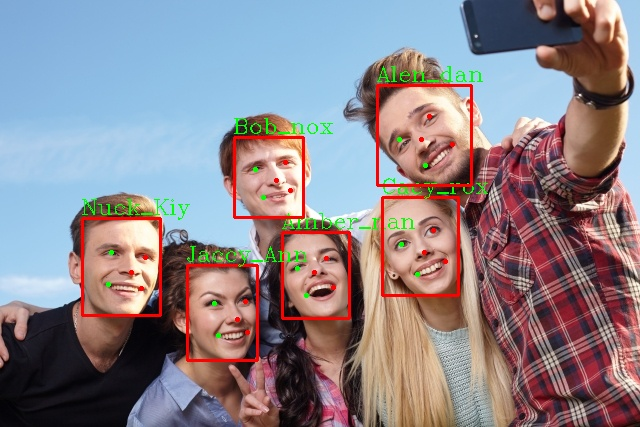

In [121]:
detect = draw_on(img, faces, pred_names)

#cv2.imwrite('/Users/tayamayuto/Face_recognition_IF/data/output/4_men.jpeg', detect)

_, buf = cv2.imencode(".jpg", detect)
display(Image(data=buf.tobytes()))